# Egraphs and Automated Reasoning
### Looking Back to Look Forward

Philip Zucker

June 22, 2024


# The Main Points of The Talk
- <b>Simplification & Completion</b>
- Union-find is Ground Atomic Completion
- E-Graph is Ground Term Completion
- ? is Lambda, Context, Destructive
- Compilers from Automated Reasoners

In the Beginning...

# ðŸ’¥ SIMPLIFICATION ðŸ’¥

# Greedy Simplification
- ex: $a + 0 \rightarrow a$
- Good
    + Fast
    + Simple
- Bad
    + Rule Interaction / Phase Ordering $\{a * 2 \rightarrow a \ll 1; (a*b)/b \rightarrow a \}$
    + Non termination $a + b \rightarrow b + a$
    + Incompleteness / Suboptimality

 # [E-Graphs](https://egraphs-good.github.io/) ðŸ¥š
- They're Good
    + Graphical, Simple
    + Declarative-ish
    + Operational-ish
    + Fast-ish
- Many applications
- Usage Modes
    + Proving: `Term -> Term -> Bool/Proof`
    + Simplifying: `Term -> Term`


<center><img width="50%" src="./egraphs.svg"></center>

$$ a * 2 = a \ll 1 $$
$$ (a * 2) / 2 = a *(2 / 2) = a * 1 = a $$

# Refinements
- Paramodulation (60s) - Go breadth first and conditional
- Completion (70s) - Make greedy good, remove redundancy
- Superposition (90s) - Combo

# Completion
- Make Equations into "Good" Rules
    + Terminating
    + Confluent - No phase ordering problem
- Early Stopping
    + Goal Driven
    + Simplification Driven

# Basic Completion

1. Orient according to Term Order
   $$[A + 0 = A] \Rightarrow \{A + 0 \rightarrow A\}$$
2. Add critical pairs (CPs) as equations
    $$\{foo(bar(X)) \rightarrow biz(X);  bar(X) \rightarrow baz(X)\} \Rightarrow $$
    $$ [biz(X) = foo(baz(X))]$$
4. Reduce Equations
    $$[a = b], \{a \rightarrow c\} \Rightarrow [c = b], \{a \rightarrow c\}$$
5. Repeat

# More Advanced Completion
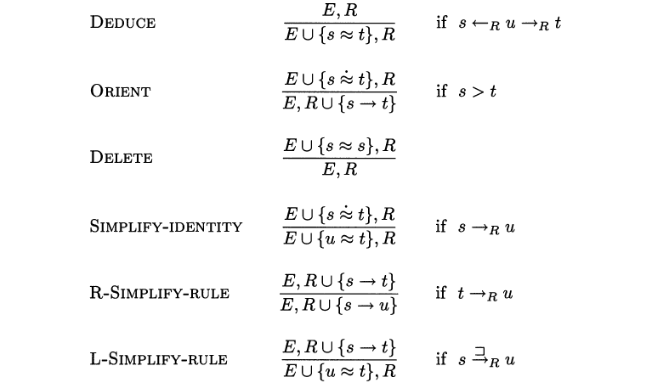

Src: Baader and Nipkow

# [Twee](https://nick8325.github.io/twee/)
- Theorem prover for equational logic
- It is built around completion
- Optimized Haskell
- [TPTP](https://www.tptp.org/) input
- [CASC UEQ](https://tptp.org/CASC/)

In [1]:
%%file /tmp/shift.p
fof(shift, axiom, ![X] : mul(X,two) = shift(X, one)).
fof(cancel, axiom, ![X,N] : div(mul(X,N),N) = X).

fof(goal, conjecture, true = false).

Overwriting /tmp/shift.p


In [2]:
!twee /tmp/shift.p

Here is the input problem:
  Axiom 1 (shift): mul(X, two) = shift(X, one).
  Axiom 2 (cancel): div(mul(X, Y), Y) = X.
  Goal 1 (goal): true = false.

1. mul(X, two) -> shift(X, one)
2. div(mul(X, Y), Y) -> X
3. div(shift(X, one), two) -> X

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  mul(X, two) -> shift(X, one)
  div(mul(X, Y), Y) -> X
  div(shift(X, one), two) -> X

RESULT: CounterSatisfiable (the conjecture is false).


# The Main Points of The Talk
- Simplification & Completion
- <b>Union-find is Ground Atomic Completion</b>
- E-Graph is Ground Term Completion
- ? is Lambda, Context, Destructive
- Compilers from Automated Reasoners

# Union Finds as Atomic Rewrite Systems
- Egraph ~ union find + hash cons
- Union find
  + forest of equivalence classes
  + Pointers up to parents
- Find = Convergent Dynamical System
- Convergent Dynamic System = Confluent Abstract Rewrite System

<font size="10"> 
    
| TRS | UF |
|------|---------------|
| Run TRS  |           Find    |
|  Add equation   |        Union     |
| R/L simplify | Compression |
| Term Ordering | Tie Breaking |

</font>

In [3]:
%%file /tmp/unionfind.p
cnf(ax1, axiom, a = b).
cnf(ax2, axiom, b = c).
cnf(ax3, axiom, c = d).
cnf(ax4, axiom, d = e).
cnf(ax5, axiom, f = g).

cnf(false, conjecture, true = false).

Overwriting /tmp/unionfind.p


In [4]:
!twee /tmp/unionfind.p

Here is the input problem:
  Axiom 1 (ax5): f = g.
  Axiom 2 (ax1): a = b.
  Axiom 3 (ax2): b = c.
  Axiom 4 (ax4): d = e.
  Axiom 5 (ax3): c = d.
  Goal 1 (false): true = false.

1. g -> f
2. b -> a
3. c -> a
4. d -> e
5. e -> a

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  b -> a
  c -> a
  d -> a
  e -> a
  g -> f

RESULT: CounterSatisfiable (the conjecture is false).


In [5]:
import graphviz
def node(e):
    #print(e, e.get_id())
    return str(e.get_id())

def graphviz_of_z3(e, dot):
    #label = "<head>" + e.decl().name() + "| {" + "|".join([ f"<p{n}>{n}" for n in range(e.num_args())]) + "}"
    if e.num_args() == 0:
        label = f'{{<head>{e.decl().name()}}}'
    else:
        label = f'{{<head>{e.decl().name()}|{{{"|".join([f"<p{n}>" for n in range(e.num_args())])}}}}}'
    #print(label)
    dot.node(node(e), label, shape="Mrecord") # id?
    for n,c in enumerate(e.children()):
        a,b = node(e) + ":p" + str(n) , node(c) + ":head"
        if (a,b) not in dot.added_edges:
            dot.added_edges.add((a,b))
            dot.edge(a,b)
        graphviz_of_z3(c, dot)

def show_rewrite(R):
    dot = graphviz.Digraph()
    dot.added_edges = set()
    for l,r in R:

        dot.edge(node(l) + ":head", node(r) + ":head", style="dashed", color="red")
        graphviz_of_z3(l,dot)
        graphviz_of_z3(r,dot)
    return dot
from z3 import *
a,b,c,d,e,f,g = Consts("a b c d e f g", IntSort())

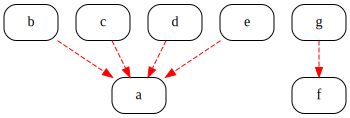

In [6]:
R = [
    (b,a),
    (c,a),
    (d,a),
    (e,a),
    (g,f)
]
show_rewrite(R)

$$ b \rightarrow a $$
$$  c \rightarrow a $$
$$  d \rightarrow a $$
$$  e \rightarrow a $$
$$  g \rightarrow f $$

In [7]:
%%file /tmp/unionfind.p
% Twee's "union find" is proof producing
cnf(ax1, axiom, a = b).
cnf(ax2, axiom, b = c).
cnf(ax3, axiom, c = d).
cnf(ax4, axiom, d = e).
cnf(ax5, axiom, f = g).

cnf(false, conjecture, a = e).

Overwriting /tmp/unionfind.p


In [8]:
!twee /tmp/unionfind.p

Here is the input problem:
  Axiom 1 (ax5): f = g.
  Axiom 2 (ax1): a = b.
  Axiom 3 (ax2): b = c.
  Axiom 4 (ax3): c = d.
  Axiom 5 (ax4): d = e.
  Goal 1 (false): a = e.

1. g -> f
2. b -> a
3. c -> a
4. d -> a
5. e -> a

The conjecture is true! Here is a proof.

Axiom 1 (ax1): a = b.
Axiom 2 (ax2): b = c.
Axiom 3 (ax3): c = d.
Axiom 4 (ax4): d = e.

Goal 1 (false): a = e.
Proof:
  a
= { by axiom 1 (ax1) }
  b
= { by axiom 2 (ax2) }
  c
= { by axiom 3 (ax3) }
  d
= { by axiom 4 (ax4) }
  e

RESULT: Theorem (the conjecture is true).


# The Main Points of The Talk
- Simplification & Completion
- Union-find is Ground Atomic Completion
- <b>E-Graph is Ground Term Completion</b>
- ? is Lambda, Context, Destructive
- Compilers from Automated Reasoners

# Extending To Terms
- Egraph = Completed Reduced Ground Rewrite System
- Ground completion "solves" ground equalities
- E-graph "solves" ground equalities



 <font size="10"> 
    
| TRS | Egraph |
|------|--------|
| Canonical Term | EClass |
| R/L-simplify | Canonization |
| Run Rules | Extract |
| Term Orders | Extract Objective |
| KBO Weights  |  Weights |

<font size="10"> 

In [9]:
%%file /tmp/groundshift.p
fof(shift, axiom, mul(a,two) = shift(a, one)).
fof(assoc, axiom, div(mul(a,two),two) = mul(a,div(two,two))).
fof(cancel, axiom, div(two,two) = one).
fof(unit_mul, axiom, mul(a,one) = a). 
fof(cancel, axiom, start_term(q,q,q,q,q,q,q) = div(mul(a,two), two)).

fof(goal, conjecture, true = false).

Overwriting /tmp/groundshift.p


In [10]:
!twee /tmp/groundshift.p

Here is the input problem:
  Axiom 1 (cancel): div(two, two) = one.
  Axiom 2 (unit_mul): mul(a, one) = a.
  Axiom 3 (shift): mul(a, two) = shift(a, one).
  Axiom 4 (assoc): div(mul(a, two), two) = mul(a, div(two, two)).
  Axiom 5 (cancel): start_term(q, q, q, q, q, q, q) = div(mul(a, two), two).
  Goal 1 (goal): true = false.

1. div(two, two) -> one
2. mul(a, one) -> a
3. mul(a, two) -> shift(a, one)
4. div(shift(a, one), two) -> a
5. start_term(q, q, q, q, q, q, q) -> a

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  mul(a, two) -> shift(a, one)
  mul(a, one) -> a
  div(two, two) -> one
  div(shift(a, one), two) -> a
  start_term(q, q, q, q, q, q, q) -> a

RESULT: CounterSatisfiable (the conjecture is false).


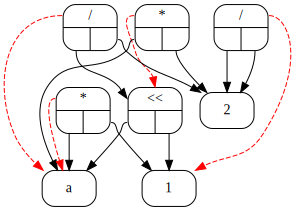

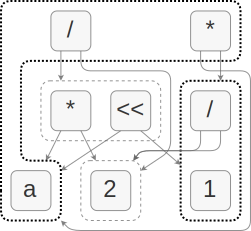

In [11]:
BV = DeclareSort("BV")
mul = Function("*", BV, BV, BV)
shift = Function("\<\<", BV, BV, BV)
div = Function("/", BV, BV, BV)
a,one,two= Consts("a 1 2", BV)
start = Const("start", BV)
R = [
  (mul(a, two) , shift(a, one)),
  (mul(a, one) , a),
  (div(two, two) , one),
  (div(shift(a, one), two) , a),
  #(start , a)
]
from IPython.display import SVG, display
display(show_rewrite(R))
show_rewrite(R).render("./egraph2.txt")
display(SVG(filename="./egraphs_1.svg"))

# WAKEUP! THE MOST IMPORTANT SLIDE!!!

<center> <img src="./egraph2.svg">
<img src="./egraphs_1.svg">
</center>


$$  mul(a, two) \rightarrow shift(a, one) $$
$$  mul(a, one) \rightarrow a $$
$$ div(two, two) \rightarrow one $$
$$  div(shift(a, one), two) \rightarrow a $$

# Where are the E-classes and E-nodes?
- Flattening
    + Introduce fresh constants for every term
    + Make them less in term ordering


$$foo(biz(baz), bar) = bar$$

--------------------- 

$$bar = e1$$
$$baz = e2$$
$$biz(e2) = e3$$
$$foo(e3,e1) = e4$$
$$e4 = e1$$



$$foo(biz(baz), bar) = bar$$

----------------------

$$bar \rightarrow e1$$
$$baz \rightarrow e2$$
$$biz(e2) \rightarrow  e3$$
$$foo(e3,e1) \rightarrow e4$$
$$e4 \rightarrow e1$$

- Two types of rules
    + $foo(e7,e4) \rightarrow e1$ = enode table 
    + $e3 \rightarrow e1$ = union find
- Observations:
    + _Not_ obviously possible for scoped terms. Slots? $e1(X,Y)$
    + Completion _is_ an egraph with Universal (forall) variables / first class rules
    + Tree Automata $cons(q1, q2) \rightarrow q2$

# E-matching
- Equality saturation
  + E-match into egraphs
  + Add new equality
- Run rules in reverse to generate all equivalent terms
- Top down and bottom up


## Bottom up E-matching
- The simplest e-matching algorithm
    + Completely guess each pattern var
    + Build term corresponding to pattern
- Plays nicer
    + Theories (Commutativity via sorting)
    + Containers
    + Grobner bases?
    + Destructive rules?
- Perhaps related to aegraph

# Strategies
<center> $\frac{A \lor B \quad \neg A \lor C}{B \lor C} $ </center>

- Incomplete but pragmatic limitations on resolution
    + Set of Support - Rules vs EGraph
    + Prolog
    + Datalog ~ Hyperresolution + UR-resolution

<font size="5"> 

| Prop | Equational |
|------|------------|
| Resolution     |   Paramodulation         |
| Ordered Resolution | Superposition |
| ?  | Completion |
| Ground Ordered Resolution | E-graph / Ground Completion / Ground Superposition |
| Prolog | Functional Logic Programming |
| Datalog | Egglog |
| ASP | ? |
| Lambda Prolog | ? |
| Hypothetical Datalog | ? |
| Minikanren | ? |

</font>

# The Main Points of The Talk
- Simplification & Completion
- Union-find is Ground Atomic Completion
- E-Graph is Ground Term Completion
- <b>? is Lambda, Context, Destructive</b>
- Compilers from Automated Reasoners

# Mysteries and Promises
- Context
- Lambdas
- Destructive

# Context
- Twee
    + Efficient encodings of first-order Horn formulas in equational logic - Claessen & Smallbone
    + In Twee today.
    + Similar to ASSUME nodes
- Ground Superposition _is_ a contextual egraph
    + Negative literal ~ context
    + Terminating but possibly explosive

$$\frac{s \approx t \quad \neg u \approx v \lor R}{\neg u[s / t] \approx v \lor R}$$

$$\frac{s \approx t \quad u \approx v \implies R}{ u[s / t] \approx v \implies R}$$

[E â€“ A Brainiac Theorem Prover](https://wwwlehre.dhbw-stuttgart.de/~sschulz/PAPERS/Schulz-AICOM-2002.pdf)

# Lambda
- Complete and Efficient Higher-Order Reasoning via Lambda-Superposition - Alexander Bentkamp, Jasmin Blanchette, Visa Nummelin, Sophie Tourret, and Uwe Waldmann
    + Zipperposition and E
- A Combinator-Based Superposition Calculus for Higher-Order Logic - Ahmed Bhayat, Giles Reger
    + Vampire
- Lambda Free Higher Order Logic (LFHOL)

# Destructive Rewriting
- Combination Problems (Chapter 9 TRAAT)
- Under what conditions does completion of Ground Eq + Rules stay well behaved?
  + Term Ordering of destructive rules probably informs how ground should work
- Two senses of "E-matching"

# The Main Points of The Talk
- Union find E-Graph $\leftrightarrow$ Ground Atomic Completion
- Clues: Lambda, Context, Destructive
- Automated Reasoning $\rightarrow$ Compilers
    + Fast Implementation?
    + Simplifier Oriented `Term -> Term`

# Thank You
- Abstract https://github.com/philzook58/egraphs2024-talk/blob/main/egraphs2024.pdf
- Blog posts:
    + https://www.philipzucker.com/egraph-ground-rewrite/
    + https://www.philipzucker.com/ground-rewrite-2/
    + https://www.philipzucker.com/bottom_up/
- References
  + Term Rewriting and All That (TRAAT)
  + Handbook of Automated Reasoning
  + Automated Reasoning: Introduction and Applications


In [1]:
%%file /tmp/context.p
% Twee as a contexual egraph/union find
fof(shift, axiom, (a = b) => b = c).
fof(cancel, axiom, c = d ).
fof(cancel, axiom, e = f ).

fof(goa,conjecture, true = false).

Overwriting /tmp/context.p


In [2]:
!twee /tmp/context.p

Here is the input problem:
  Axiom 1 (cancel): e = f.
  Axiom 2 (cancel): c = d.
  Axiom 3 (ifeq_axiom): ifeq(X, X, Y, Z) = Y.
  Axiom 4 (shift): ifeq(a, b, b, c) = c.
  Goal 1 (goa): true = false.

1. f -> e
2. c -> d
3. ifeq(X, X, Y, Z) -> Y
4. ifeq(a, b, b, d) -> d

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  c -> d
  f -> e
  ifeq(X, X, Y, Z) -> Y
  ifeq(a, b, b, d) -> d

RESULT: CounterSatisfiable (the conjecture is false).


In [12]:
def simplify1(x):
    match x:
        case ("add", ("const", m), ("const", n)):
            return ("const", m + n)
        case ("add", ("const", 0), y) | ("add", y, ("const", 0)):
            return y
        case _:
            return x
def simplify(expr):
    match expr:
        case ("add", x, y):
            return simplify1(("add", simplify(x), simplify(y)))
        case _:
            return simplify1(expr)
simplify(("add", ("const", 3), ("const", 4)))

('const', 7)

In [13]:
class UF():
    def __init__(self):
        self.rules = {}
    def find(self, x):
        # `find` reduces x with respect to the current rules (x -R-> retval)
        while self.rules.get(x) != None:
            x = self.rules.get(x)
        return x
    def union(self, x, y):
        # Do incremental completion starting with
        # (E,R) == ({x = y}, self.rules )
        x1 = self.find(x) # SIMPLIFY  ( {x1 = y} , R)
        y1 = self.find(y) # SIMPLIFY  ( {x1 = y1}, R)
        if x1 == y1: # TRIVIAL ({x1 = x1}, R)
            return x1 # (Empty, self.rules)
        else:
            if x1 < y1: # the "term order"
                x1,y1 = y1,x1 # swap
            self.rules[x1] = y1 # ORIENT  (empty, R U {x1 -> y1})
            return y1
    def canon(self):
        for lhs,rhs in self.rules.items():
            self.rules[lhs] = self.find(rhs) # r-simplify

# Tree Automata
- Strings ~ single argument terms $aaabb = a(a(a(a(b(b(\epsilon))))))$
- Term rewriting formulation of DFA
    + $a^*b^* = \{a(q1) \rightarrow q1, a(q0) \rightarrow q1, b(q0) \rightarrow q0\}$
    + $a(a(a(a(b(b(q0)))))) \rightarrow^? q1$ 
- Generalizes to Tree. Finite State Folds
- Call $q1$ $e1$ and we have a flattened egraph

![](./res_cube.png)
Src: [Blanchette](https://events.model.in.tum.de/mod23/blanchette/Lecture3-Lambda-Superposition.pdf)

In [14]:
%%file /tmp/groundshift.p
fof(e, axiom, a = e0).
fof(e, axiom, two = e1).
fof(e, axiom, mul(a,two) = e2).
fof(e, axiom, div(mul(a,two),two) = e3).
fof(e, axiom, one = e4).
fof(e, axiom, shift(a, one) = e5).
fof(e, axiom, div(two,two) = e6).
fof(e, axiom, mul(a, one) = e7).

fof(shift, axiom, mul(a,two) = shift(a, one)).
fof(assoc, axiom, div(mul(a,two),two) = mul(a,div(two,two))).
fof(cancel, axiom, div(two,two) = one).
fof(unit_mul, axiom, mul(a,one) = a). 
fof(cancel, axiom, start_term(q,q,q,q,q,q,q) = div(mul(a,two), two)).

fof(goal, conjecture, true = false).

Overwriting /tmp/groundshift.p


In [15]:
!twee /tmp/groundshift.p

Here is the input problem:
  Axiom 1 (e): one = e4.
  Axiom 2 (e): a = e0.
  Axiom 3 (e): two = e1.
  Axiom 4 (e): shift(a, one) = e5.
  Axiom 5 (e): div(two, two) = e6.
  Axiom 6 (cancel): div(two, two) = one.
  Axiom 7 (e): mul(a, one) = e7.
  Axiom 8 (unit_mul): mul(a, one) = a.
  Axiom 9 (e): mul(a, two) = e2.
  Axiom 10 (shift): mul(a, two) = shift(a, one).
  Axiom 11 (e): div(mul(a, two), two) = e3.
  Axiom 12 (assoc): div(mul(a, two), two) = mul(a, div(two, two)).
  Axiom 13 (cancel): start_term(q, q, q, q, q, q, q) = div(mul(a, two), two).
  Goal 1 (goal): true = false.

1. one -> e4
2. a -> e0
3. two -> e1
4. shift(e0, e4) -> e5
5. div(e1, e1) -> e6
6. e6 -> e4
7. mul(e0, e4) -> e7
8. e7 -> e0
9. mul(e0, e1) -> e2
10. e5 -> e2
11. div(e2, e1) -> e3
12. e3 -> e0
13. start_term(q, q, q, q, q, q, q) -> e0

Ran out of critical pairs. This means the conjecture is not true.
Here is the final rewrite system:
  a -> e0
  two -> e1
  e3 -> e0
  one -> e4
  e5 -> e2
  e6 -> e4
  e7 -> e

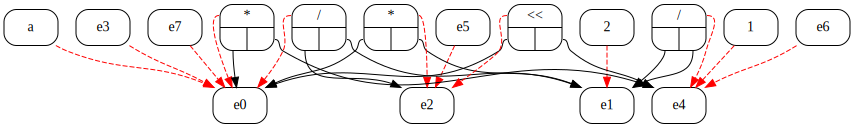

In [16]:
BV = DeclareSort("BV")
mul = Function("*", BV, BV, BV)
shift = Function("\<\<", BV, BV, BV)
div = Function("/", BV, BV, BV)
a,one,two= Consts("a 1 2", BV)
e0,e1,e2,e3,e4,e5,e6,e7 = Consts("e0 e1 e2 e3 e4 e5 e6 e7", BV)
start = Const("start", BV)
R = [
    (a, e0),
    (two, e1),
    (e3, e0),
    (one,e4),
    (e5,e2),
    (e6,e4),
    (e7,e0),
    (mul(e0,e1),e2),
    (mul(e0,e4), e0),
    (div(e1,e1),e4),
    (div(e2,e1), e0),
    (shift(e0,e4), e2),
    #(start, e0)
]
show_rewrite(R)

In [17]:
%%file /tmp/shift.p
fof(shift, axiom, ![X] : mul(X,two) = shift(X, one)).

fof(assoc, axiom, ![X,Y,Z]: div(mul(X,Y), Z) = mul(X, div(Y,Z))).
fof(cancel, axiom, ![X]: div(X,X) = one).
fof(mul_one, axiom, ![X]: mul(X,one) = X).

fof(goal, conjecture, true = false).

Overwriting /tmp/shift.p
